<a href="https://colab.research.google.com/github/drxxtc/adversarialAttack/blob/main/Warm_or_Cold_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv
from torchvision.transforms import ToTensor
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import sys
import os

loss_data = dict()
f1_data = dict()
accuracy_data = dict()

loss_data['train'] = []
loss_data['test'] = []
f1_data['train'] = []
f1_data['test'] = []
accuracy_data['train'] = []
accuracy_data['test'] = []

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Dataset2Class(torch.utils.data.Dataset):
    def __init__(self, path_dir:str):
        super().__init__()
        self.path_dir = path_dir
        self.data = np.genfromtxt(path_dir)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, index):
        t_data = torch.from_numpy(self.data[index][1:]).to(torch.float32)
        t_data = torch.reshape(t_data, (1, 144))
        t_label = torch.tensor(int(self.data[index][0]) - 1)
        return {'data': t_data, 'label': t_label}

In [ ]:
train_data = '/content/drive/MyDrive/data/PowerCons_TRAIN.txt'
test_data = '/content/drive/MyDrive/data/PowerCons_TEST.txt'

In [ ]:
train_dataset = Dataset2Class(train_data)
test_dataset = Dataset2Class(test_data)

In [ ]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True,
    batch_size=batch_size, num_workers=0, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False,
    batch_size=batch_size, num_workers=1, drop_last=False
)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool1d(2)
        self.conv1 = nn.Conv1d(1, 4, 3, stride=1, padding=0)
        self.conv2 = nn.Conv1d(4, 16, 3, stride=1, padding=0)
        self.conv3 = nn.Conv1d(16, 32, 3, stride=1, padding=0)
        self.adaptivepool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 2)

    def forward(self, x):

        out = self.maxpool(self.act(self.conv1(x)))
        out = self.maxpool(self.act(self.conv2(out)))
        out = self.maxpool(self.act(self.conv3(out)))

        out = self.adaptivepool(out)

        out = self.flatten(out)
        out = self.act(self.linear1(out))
        out = self.linear2(out)

        return out

In [ ]:
model = ConvNet()
model

ConvNet(
  (act): LeakyReLU(negative_slope=0.2)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(4, 16, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (adaptivepool): AdaptiveAvgPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

2354


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cpu


In [ ]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach(), dim=1).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

In [ ]:
def validation(model:ConvNet):
    loss_val = 0
    acc_val = 0
    pr = torch.tensor([])
    lb = torch.tensor([])
    model = model.to("cpu")
    for sample in test_loader:

        label = sample['label']
        label = F.one_hot(label, 2).float()
        data = sample['data']

        pred = model(data)
        loss = loss_fn(pred, label)

        loss_item = loss.item()
        loss_val += loss_item

        pr = torch.cat((pr, pred))
        lb = torch.cat((lb, label))
        acc_current = accuracy(pred, label)
        acc_val += acc_current

    model = model.to(device)

    pr = F.softmax(pr.detach(), dim=1).numpy().argmax(1)
    lb = F.softmax(lb.detach(), dim=1).numpy().argmax(1)

    loss_data['test'].append(loss_val/len(test_loader))
    accuracy_data['test'].append(acc_val/len(test_loader))
    f1_data['test'].append(f1_score(lb, pr, average="macro"))

    return loss_val/len(train_loader), acc_val/len(test_loader), f1_score(lb, pr, average="macro")

In [ ]:
epochs = 25
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    pr = torch.tensor([])
    lb = torch.tensor([])
    for sample in (pbar := tqdm(train_loader)):

        optimizer.zero_grad()

        label = sample['label']
        label = F.one_hot(label, 2).float()
        data = sample['data']

        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred, label)
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

        pr = torch.cat((pr, pred.cpu().float()))
        lb = torch.cat((lb, label.cpu().float()))
        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current

    pr = F.softmax(pr.detach(), dim=1).numpy().argmax(1)
    lb = F.softmax(lb.detach(), dim=1).numpy().argmax(1)

    loss_data['train'].append(loss_val/len(train_loader))
    accuracy_data['train'].append(acc_val/len(train_loader))
    f1_data['train'].append(f1_score(lb, pr, average="macro"))

    valid = validation(model)
    f1 = f1_score(lb, pr, average="macro")
    print(f"Train loss: {loss_val/len(train_loader)}\t\tValidation loss: {valid[0]}")
    print(f"Train accuracy: {acc_val/len(train_loader)}\tValidation accuracy: {valid[1]}")
    print(f"Train F1-score: {f1}\tValidation F1-socre: {valid[2]}")

  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.672190781434377		Validation loss: 0.621116246117486
Train accuracy: 0.5777777777777777	Validation accuracy: 0.8444444444444444
Train F1-score: 0.5074884792626728	Validation F1-socre: 0.8434977021488015


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.5762724379698435		Validation loss: 0.46402536034584047
Train accuracy: 0.7833333333333333	Validation accuracy: 0.8611111111111112
Train F1-score: 0.780892037828896	Validation F1-socre: 0.8595461780954461


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.39039781623416475		Validation loss: 0.31257566395733094
Train accuracy: 0.8611111111111112	Validation accuracy: 0.8444444444444444
Train F1-score: 0.8611068242847002	Validation F1-socre: 0.8434977021488015


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.3364555441670948		Validation loss: 0.30909222608639136
Train accuracy: 0.8722222222222222	Validation accuracy: 0.85
Train F1-score: 0.8721235521235522	Validation F1-socre: 0.848951048951049


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.3281094895468818		Validation loss: 0.27104988392028545
Train accuracy: 0.8555555555555555	Validation accuracy: 0.8777777777777778
Train F1-score: 0.85553772070626	Validation F1-socre: 0.8777777777777779


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.32323636553353735		Validation loss: 0.26904172264039516
Train accuracy: 0.8555555555555555	Validation accuracy: 0.8722222222222222
Train F1-score: 0.85553772070626	Validation F1-socre: 0.8721867185329257


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.3117644800080193		Validation loss: 0.2680273098457191
Train accuracy: 0.8722222222222222	Validation accuracy: 0.9055555555555556
Train F1-score: 0.8721235521235522	Validation F1-socre: 0.9053188526872737


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.30994040473467777		Validation loss: 0.2625610457526313
Train accuracy: 0.8611111111111112	Validation accuracy: 0.8888888888888888
Train F1-score: 0.8611068242847002	Validation F1-socre: 0.8887652947719689


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.30652121889094514		Validation loss: 0.2740732518542144
Train accuracy: 0.8833333333333333	Validation accuracy: 0.8722222222222222
Train F1-score: 0.883329732399148	Validation F1-socre: 0.872028685357485


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.30401678764157825		Validation loss: 0.2597331445560687
Train accuracy: 0.8722222222222222	Validation accuracy: 0.8888888888888888
Train F1-score: 0.8722182783419242	Validation F1-socre: 0.8888751697740462


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.31678018276062275		Validation loss: 0.2648652339457638
Train accuracy: 0.8777777777777778	Validation accuracy: 0.8833333333333333
Train F1-score: 0.8777626867514509	Validation F1-socre: 0.8833009169213671


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.30758506916463374		Validation loss: 0.26728171275721657
Train accuracy: 0.8777777777777778	Validation accuracy: 0.9
Train F1-score: 0.8777173913043479	Validation F1-socre: 0.8995535714285714


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.31720295602248777		Validation loss: 0.25921256550484234
Train accuracy: 0.85	Validation accuracy: 0.9055555555555556
Train F1-score: 0.8498841698841699	Validation F1-socre: 0.9053188526872737


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.2989596120392283		Validation loss: 0.2589811552936832
Train accuracy: 0.8888888888888888	Validation accuracy: 0.8944444444444445
Train F1-score: 0.8888751697740462	Validation F1-socre: 0.8940487623532327


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.30591595065262583		Validation loss: 0.2573036339547899
Train accuracy: 0.8666666666666667	Validation accuracy: 0.9
Train F1-score: 0.866600790513834	Validation F1-socre: 0.8996904024767802


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.29872245101465117		Validation loss: 0.2923849239945412
Train accuracy: 0.8722222222222222	Validation accuracy: 0.8777777777777778
Train F1-score: 0.8722182783419242	Validation F1-socre: 0.8768043802887008


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.2968578723569711		Validation loss: 0.2592379545999898
Train accuracy: 0.8722222222222222	Validation accuracy: 0.9
Train F1-score: 0.8722182783419242	Validation F1-socre: 0.8995535714285714


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.28669877542803685		Validation loss: 0.24528717607673672
Train accuracy: 0.8833333333333333	Validation accuracy: 0.9111111111111111
Train F1-score: 0.8833009169213671	Validation F1-socre: 0.9109351806036616


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.28569804396894244		Validation loss: 0.26218507008420094
Train accuracy: 0.8777777777777778	Validation accuracy: 0.8888888888888888
Train F1-score: 0.8777777777777779	Validation F1-socre: 0.888212644392001


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.2894942640016476		Validation loss: 0.26179907828983334
Train accuracy: 0.9055555555555556	Validation accuracy: 0.8888888888888888
Train F1-score: 0.9055293136982496	Validation F1-socre: 0.888212644392001


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.2740666094753477		Validation loss: 0.27854383726500803
Train accuracy: 0.9	Validation accuracy: 0.8888888888888888
Train F1-score: 0.899888765294772	Validation F1-socre: 0.8883928571428571


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.29760953924722144		Validation loss: 0.2365839268805252
Train accuracy: 0.8777777777777778	Validation accuracy: 0.9277777777777778
Train F1-score: 0.8777173913043479	Validation F1-socre: 0.927757710475132


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.27654023946573336		Validation loss: 0.23932648742985393
Train accuracy: 0.9	Validation accuracy: 0.9166666666666666
Train F1-score: 0.899888765294772	Validation F1-socre: 0.9166640945708201


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.2793500512424443		Validation loss: 0.24221422442545493
Train accuracy: 0.8777777777777778	Validation accuracy: 0.9166666666666666
Train F1-score: 0.8777626867514509	Validation F1-socre: 0.9166435120866907


  0%|          | 0/45 [00:00<?, ?it/s]

Train loss: 0.2822256202912993		Validation loss: 0.2366608029852311
Train accuracy: 0.8666666666666667	Validation accuracy: 0.9222222222222223
Train F1-score: 0.8666666666666667	Validation F1-socre: 0.9222222222222223


In [ ]:
def draw():
    plt.figure(figsize=(15, 10))

    # График функции потерь CrossEntropy
    plt.subplot(2, 2, 1)
    plt.plot(loss_data['train'], label='Train CrossEntropy Loss')
    plt.plot(loss_data['test'], label='Validation CrossEntropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CrossEntropy Loss')
    plt.legend()

    # График Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_data['train'], label='Train Precision')
    plt.plot(accuracy_data['test'], label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # График F1-score
    plt.subplot(2, 2, 3)
    plt.plot(f1_data['train'], label='Train F1-score')
    plt.plot(f1_data['test'], label='Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('F1-score')
    plt.legend()

    plt.show()

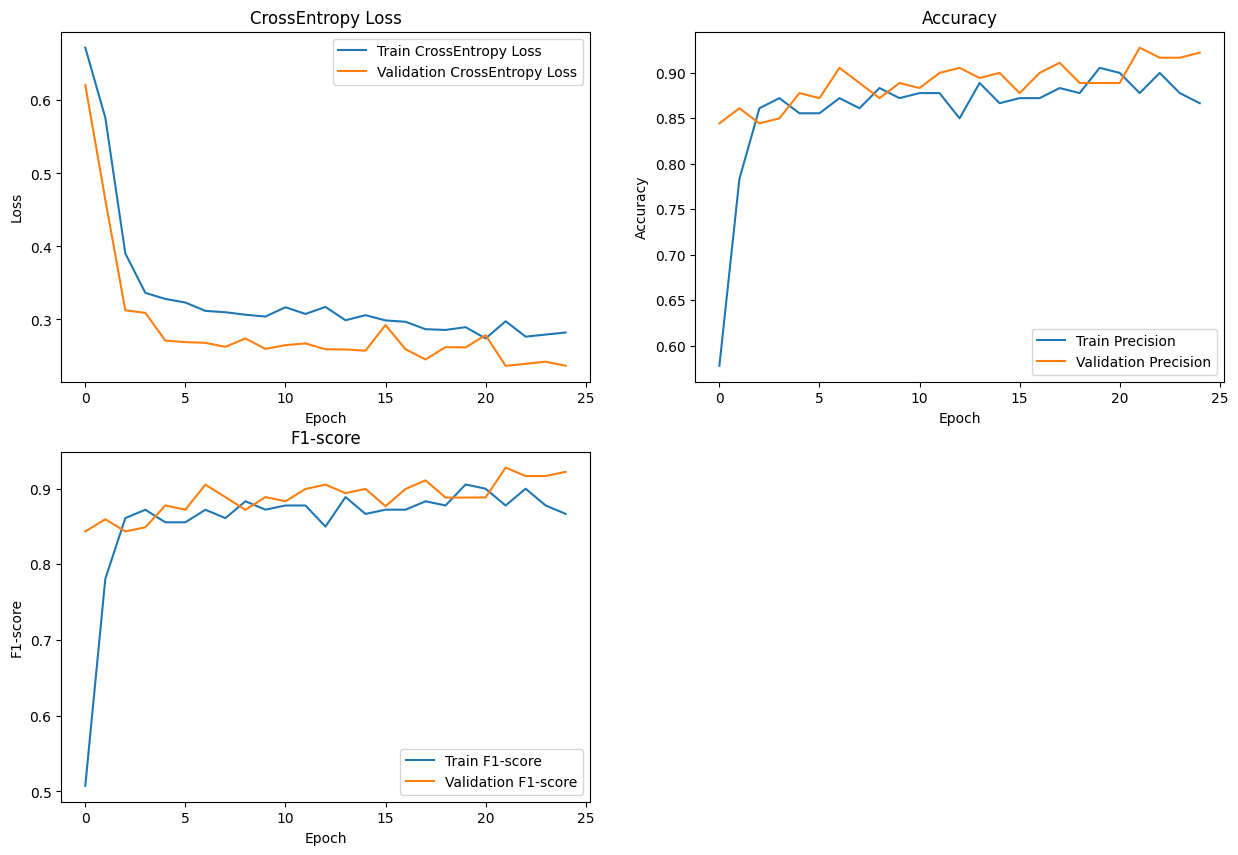

In [ ]:
draw()